<a href="https://colab.research.google.com/github/EX1cyclone/635_project_pollution_detect/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

# Load dataset
file_path = '/content/drive/MyDrive/ECE635/beijing+multi+site+air+quality+data/PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Handling missing values with linear spline interpolation
data.interpolate(method='linear', inplace=True)

# Encode categorical variables (Example: Wind Direction)
# Replace 'wind_direction_column' with your actual column name
if 'wind_direction_column' in data.columns:
    data['wind_direction_encoded'] = data['wind_direction_column'].apply(lambda x: ... )  # Define your encoding logic

# Normalize PM2.5 concentration and other features
scaler = MinMaxScaler()
data['PM2.5_normalized'] = scaler.fit_transform(data[['PM2.5']])  # Replace 'PM2.5' with your actual column name

# Feature selection using Pearson correlation
correlation_threshold = 0.5  # Define your correlation threshold
correlation_matrix = data.corr()
features = correlation_matrix.index[abs(correlation_matrix["PM2.5_normalized"]) > correlation_threshold]

# Selected features dataset
selected_data = data[features]


<ipython-input-2-b88a55376396>:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'selected_data' is your preprocessed dataset
X = selected_data.drop('PM2.5_normalized', axis=1)  # Features
y = selected_data['PM2.5_normalized']  # Target variable

# Splitting the dataset into training and testing sets
# Adjust test_size as needed (e.g., 0.2 for 20%, 0.3 for 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert Pandas DataFrame to NumPy array and then reshape
num_features = X_train.shape[1]  # Number of features
num_timesteps = 1  # Set to 1 if your data is not time-series

X_train_reshaped = X_train.values.reshape((-1, num_timesteps, num_features))
X_test_reshaped = X_test.values.reshape((-1, num_timesteps, num_features))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from sklearn.metrics import r2_score

def build_lstm_model(input_length, num_features):
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=(input_length, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
# Assuming X_train and X_test are in 2D format: [samples, features]
# Reshape them to 3D format: [samples, timesteps, features]

# Check the current shape of X_train
print("Current shape of X_train:", X_train.shape)

# Define the number of timesteps and features
num_features = X_train.shape[1]
timesteps = 1  # Set timesteps to 1 if your data is not time-series

# Reshape X_train and X_test
X_train_reshaped = X_train.values.reshape((-1, timesteps, num_features))
X_test_reshaped = X_test.values.reshape((-1, timesteps, num_features))


Current shape of X_train: (28051, 4)


Epoch 1/200
1169/1169 [==============================] - 16s 6ms/step - loss: 0.0129 - val_loss: 0.0045
Epoch 2/200
1169/1169 [==============================] - 6s 5ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 3/200
1169/1169 [==============================] - 7s 6ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 4/200
1169/1169 [==============================] - 6s 5ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 5/200
1169/1169 [==============================] - 6s 5ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 6/200
1169/1169 [==============================] - 6s 5ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 7/200
1169/1169 [==============================] - 6s 5ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 8/200
1169/1169 [==============================] - 6s 5ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 9/200
1169/1169 [==============================] - 6s 5ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 10/200
1169/1169 [==============================] - 6s 5ms/step - 

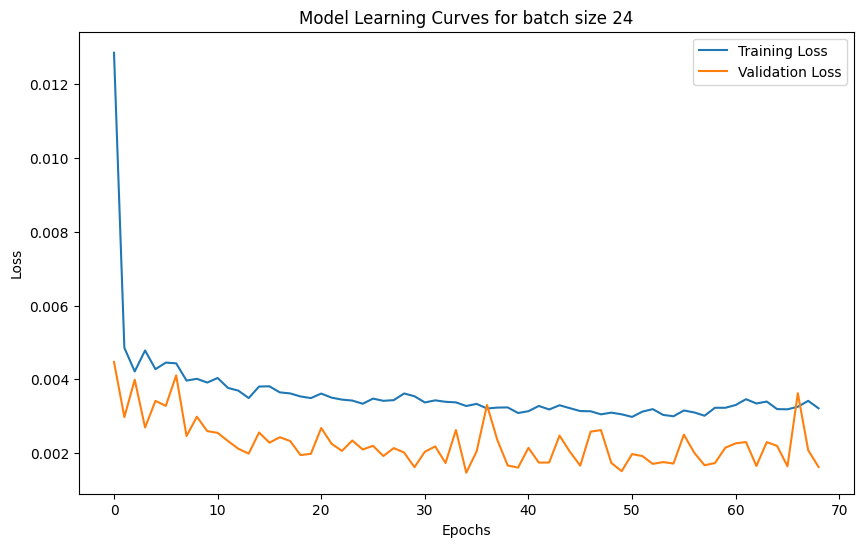

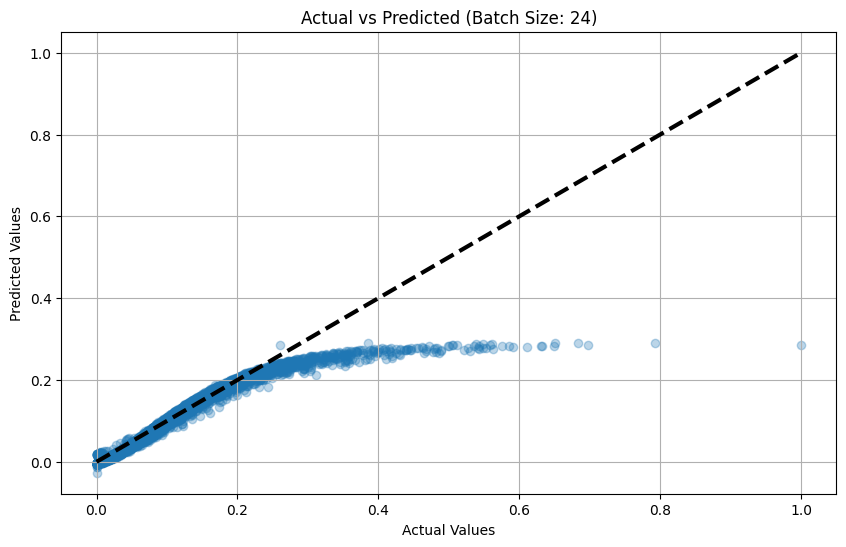

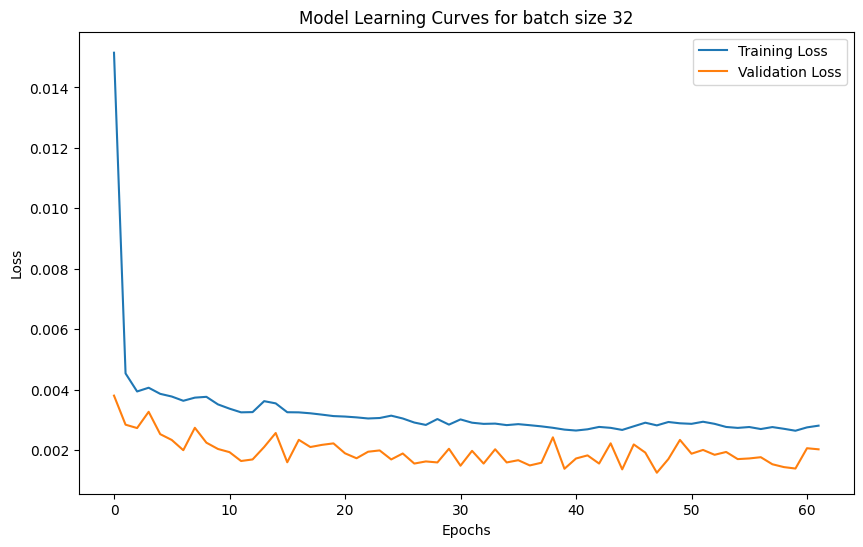

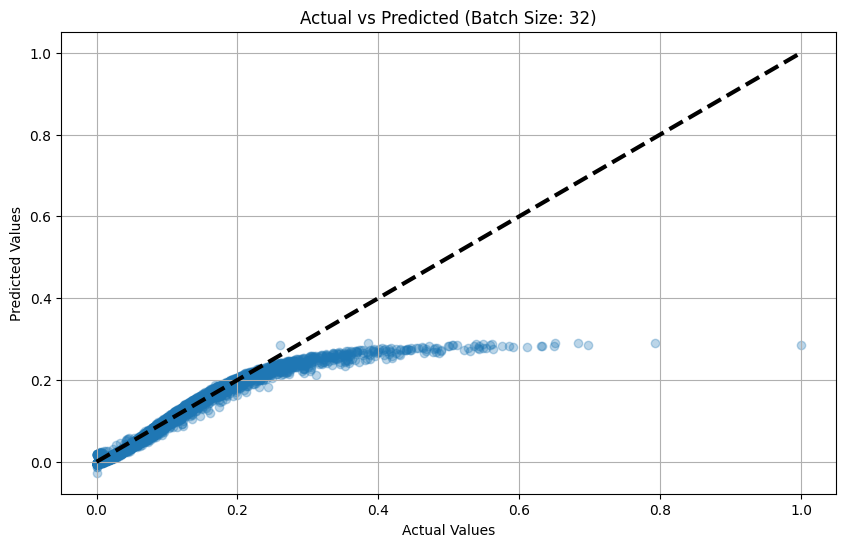

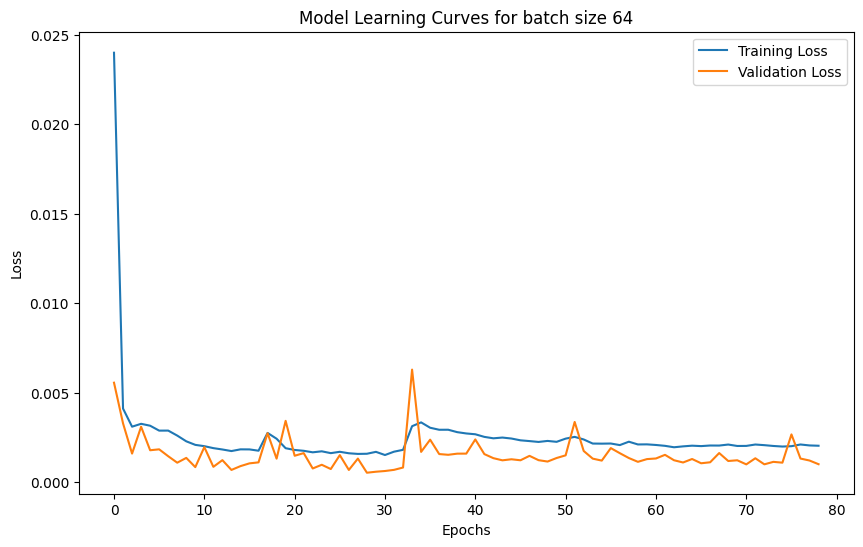

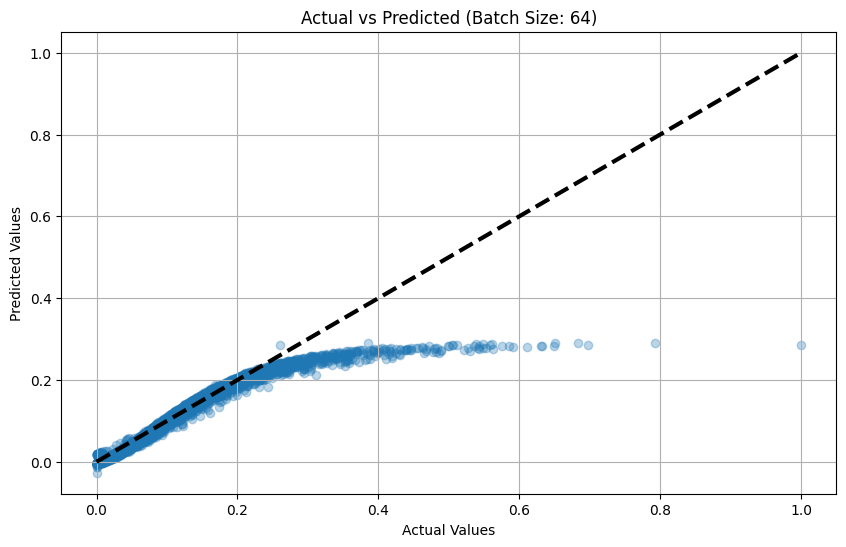

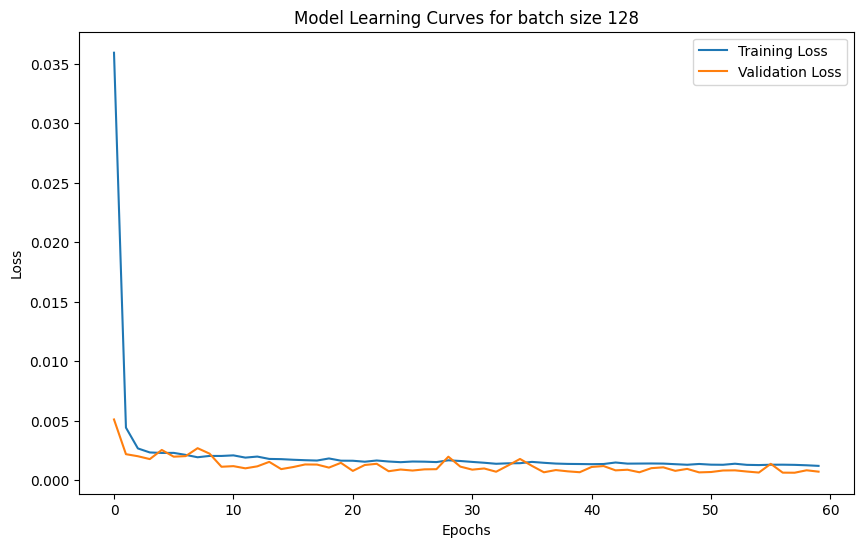

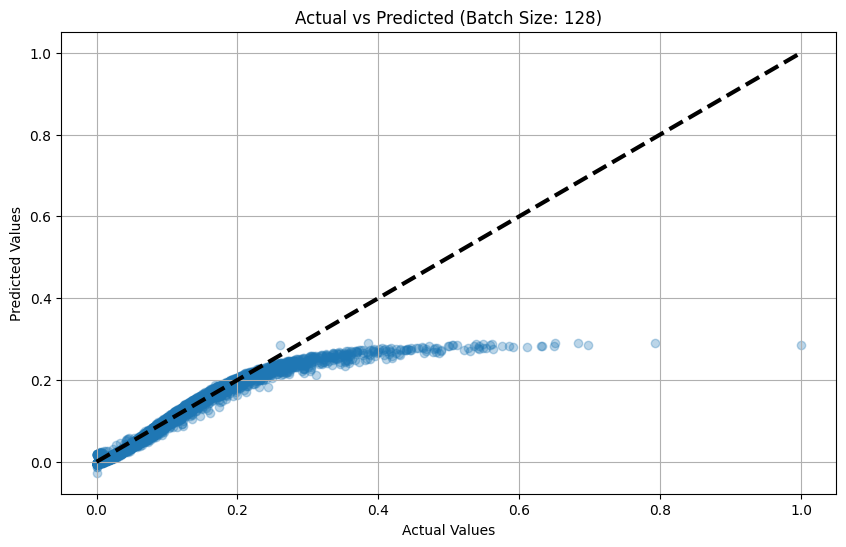

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2


def build_lstm_model(timesteps, num_features, l2_lambda=0.001):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(timesteps, num_features), kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()


batch_sizes = [24, 32, 64, 128]
results = {}
history_dict = {}

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, restore_best_weights=True)

# Build and fit the LSTM model
for batch_size in batch_sizes:
    model = build_lstm_model(timesteps, num_features)
    history = model.fit(X_train_reshaped, y_train, epochs=200, batch_size=batch_size,
                        validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])
    history_dict[batch_size] = history.history

    y_pred = model.predict(X_test_reshaped)

    # Calculate MAE, RMSE,
    mae = MeanAbsoluteError()
    rmse = RootMeanSquaredError()
    mae.update_state(y_test, y_pred)
    rmse.update_state(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[batch_size] = {
        'MAE': mae.result().numpy(),
        'RMSE': rmse.result().numpy(),
        'R2': r2
    }

for batch_size, metrics in results.items():
    print(f"Batch Size: {batch_size}, MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}, R2: {metrics['R2']}")

for batch_size, history in history_dict.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Model Learning Curves for batch size {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting the actual vs predicted
    plot_actual_vs_predicted(y_test, y_pred.flatten(), title=f'Actual vs Predicted (Batch Size: {batch_size})')
